# Analysis and Prediction of used car prices
## -Anmol Agarwal

## Aim
The aim is here to develop a ML model hat predicts the price of used cars based on its features, in order to make informed purchases. The model is trained on a dataset consisting of sale prices of different makes and models across cities in India.

## Motivation
When shopping for a used vehicle, typically an overriding concern is: **Am I paying too much?**  This question is often difficult to answer due to the fact that it's hard to keep track of all the vehicles of interest currently available on the market.

Deciding if a used car is worth the cost put by the seller is a difficult task. Even for the seller, it is a challenge to decide the selling price of a car as it should neither be too low so as to cause a loss, nor too high that it puts off potential customers. Several factors including **make,model,year,kms driven etc** can affect the actual worth of a car. The motivation of this project is to help predict correct worth of used cars.

## The Model

### Importing the required libraries

In [1]:
#importing stuff
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import nltk
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# plot styles and other settings
plt.style.use('seaborn-whitegrid')
sns.set_style('whitegrid')
pd.set_option('display.max_rows', 60)


# Dataset and preprocessing
For this project, we are using the dataset on used car sales from all
over the India.The features available in this dataset are **Mileage, Make, Model, Year, kms travelled,transmisson, fuel type and City.**

In [2]:
#specifying the excel file to be used
excel_file="Data_Train (1).xlsx"
cars = pd.read_excel(excel_file)

In [3]:
cars.shape

(6019, 12)

In [4]:
cars.dtypes

Name                  object
Location              object
Year                   int64
Kilometers_Driven      int64
Fuel_Type             object
Transmission          object
Owner_Type            object
Mileage               object
Engine                object
Power                 object
Seats                float64
Price                float64
dtype: object

In [5]:
cars.describe()

,Year,Kilometers_Driven,Seats,Price
count,6019.000000,6.019000e+03,5977.000000,6019.000000
mean,2013.358199,5.873838e+04,5.278735,9.479468
std,3.269742,9.126884e+04,0.808840,11.187917
min,1998.000000,1.710000e+02,0.000000,0.440000
25%,2011.000000,3.400000e+04,5.000000,3.500000
50%,2014.000000,5.300000e+04,5.000000,5.640000
75%,2016.000000,7.300000e+04,5.000000,9.950000
max,2019.000000,6.500000e+06,10.000000,160.000000


### Renaming columns for ease of use

In [6]:
#Setting all columns to lower case
cars.columns = [x.lower() for x in cars.columns]
cars=cars.rename(columns={"location": "city","kilometers_driven":"kms","fuel_type":"fuel",
                    "owner_type":"owner",})

### Making two new columns for "brand"(make) and model respectively

In [7]:
a1=[]
a2=[]
for s in cars["name"]:
    ary=s.split(' ')
    a1.append(ary[0])
    a2.append(ary[1])    

In [8]:
brand=pd.Series(a1)
model=pd.Series(a2)

In [9]:
brand.value_counts()

Maruti           1211
Hyundai          1107
Honda             608
Toyota            411
Mercedes-Benz     318
Volkswagen        315
Ford              300
Mahindra          272
BMW               267
Audi              236
Tata              186
Skoda             173
Renault           145
Chevrolet         121
Nissan             91
Land               60
Jaguar             40
Fiat               28
Mitsubishi         27
Mini               26
Volvo              21
Porsche            18
Jeep               15
Datsun             13
Force               3
ISUZU               2
Isuzu               1
Bentley             1
Lamborghini         1
Ambassador          1
Smart               1
dtype: int64

In [10]:
model.value_counts()

Swift         353
City          270
i20           247
Verna         170
Innova        164
             ... 
Platinum        1
Mustang         1
XUV300          1
E               1
Countryman      1
Length: 212, dtype: int64

In [11]:
cars["brand"]=brand
cars["model"]=model
cars.loc[cars["brand"]=="Land","brand"]="Land_Rover"
cars.loc[cars["brand"]=="Isuzu","brand"]="ISUZU"

___

> ***The next order of business was to find out the NULL values and the outliers and to deal with them.***

In [12]:
cars.isnull().sum()

name             0
city             0
year             0
kms              0
fuel             0
transmission     0
owner            0
mileage          2
engine          36
power           36
seats           42
price            0
brand            0
model            0
dtype: int64

> **The number of cars for whom specific data is missing is not too high. Infact, manual plugging of these values was possible in a reasonable amount of time. Hence, we tried to fill the data. Most of this data was derived from ["CarDekho.com"](www.cardekho.com)**

###### Displaying rows which have even a single null value

In [13]:
cars[cars.isnull().any(axis=1)].head()

,name,city,year,kms,fuel,transmission,owner,mileage,engine,power,seats,price,brand,model
194,Honda City 1.5 GXI,Ahmedabad,2007,60006,Petrol,Manual,First,0.0 kmpl,NaN,NaN,NaN,2.95,Honda,City
208,Maruti Swift 1.3 VXi,Kolkata,2010,42001,Petrol,Manual,First,16.1 kmpl,NaN,NaN,NaN,2.11,Maruti,Swift
229,Ford Figo Diesel,Bangalore,2015,70436,Diesel,Manual,First,0.0 kmpl,1498 CC,99 bhp,NaN,3.60,Ford,Figo
733,Maruti Swift 1.3 VXi,Chennai,2006,97800,Petrol,Manual,Third,16.1 kmpl,NaN,NaN,NaN,1.75,Maruti,Swift
749,Land Rover Range Rover 3.0 D,Mumbai,2008,55001,Diesel,Automatic,Second,0.0 kmpl,NaN,NaN,NaN,26.50,Land_Rover,Rover


___

# Preprocessing of the data
In order to get a better understanding of the data, we plotted some curves to understand the importance of the parameters.
We noticed that the dataset had several missing values and some outliers as well, primarily due to large price sensitivity of used cars. **Generally, the "mechanical health" of a car is not only dependent on the technical specs, but also on how the car has been maintained by the previous owners. Also, accident history and condition can have a significant effect on the
car’s price.** Since we did not have access to vehicle history and condition(these generally being non-quantifiable characteristics), we had to do with the available parameters.

## Dealing with anomalous values in "engine" column

In [14]:
len(cars[cars['engine'].isnull()])

36

In [15]:
cars[cars['engine'].isnull()].head()

,name,city,year,kms,fuel,transmission,owner,mileage,engine,power,seats,price,brand,model
194,Honda City 1.5 GXI,Ahmedabad,2007,60006,Petrol,Manual,First,0.0 kmpl,NaN,NaN,NaN,2.95,Honda,City
208,Maruti Swift 1.3 VXi,Kolkata,2010,42001,Petrol,Manual,First,16.1 kmpl,NaN,NaN,NaN,2.11,Maruti,Swift
733,Maruti Swift 1.3 VXi,Chennai,2006,97800,Petrol,Manual,Third,16.1 kmpl,NaN,NaN,NaN,1.75,Maruti,Swift
749,Land Rover Range Rover 3.0 D,Mumbai,2008,55001,Diesel,Automatic,Second,0.0 kmpl,NaN,NaN,NaN,26.50,Land_Rover,Rover
1294,Honda City 1.3 DX,Delhi,2009,55005,Petrol,Manual,First,12.8 kmpl,NaN,NaN,NaN,3.20,Honda,City


##### Manual handling of null values ( data derived from cardekho.com)

In [16]:
#cars.loc[(cars['model'] == 'New') & (cars['brand'] == 'Mercedes-Benz'), 'model'] = 'C-Class'
#cars[cars['engine'].isnull()].loc[cars["model"]=="Swift","engine"]=1300
le=cars["engine"].isnull()
#print(le)
for i in range(len(cars)):
    if le[i]==True:
        if cars["model"][i]=="Swift":
            cars.loc[i,"engine"]=1300
        if cars["model"][i]=="City":
            cars.loc[i,"engine"]=1500
        if cars["model"][i]=="Punto":
            cars.loc[i,"engine"]=1300
        if cars["model"][i]=="5":
            cars.loc[i,"engine"]=2000
        if cars["model"][i]=="Rover":
            cars.loc[i,"engine"]=3000
        if cars["model"][i]=="Santro":
            cars.loc[i,"engine"]=1086
        if cars["model"][i]=="Etios":
            cars.loc[i,"engine"]=1197
        if cars["model"][i]=="Wagon" or cars["model"][i]=="Wagon-R":
            cars.loc[i,"engine"]=998
        if cars["model"][i]=="CR-V":
            cars.loc[i,"engine"]=2354
        if cars["model"][i]=="Jazz":
            cars.loc[i,"engine"]=1198

In [17]:
for i in range(len(cars)):
    st=cars.loc[i,"engine"]
    #print(i)
    a=4
    b=2.0
    if type(st)!=type(a) and type(st)!=type(b):
    #print(st)
    #st=str(st)
        le=""
        for j in st:
            if j==' ':
                break
            le=le+j
        cars.loc[i,"engine"]=le

In [18]:
cars["engine"]=pd.to_numeric(cars["engine"])

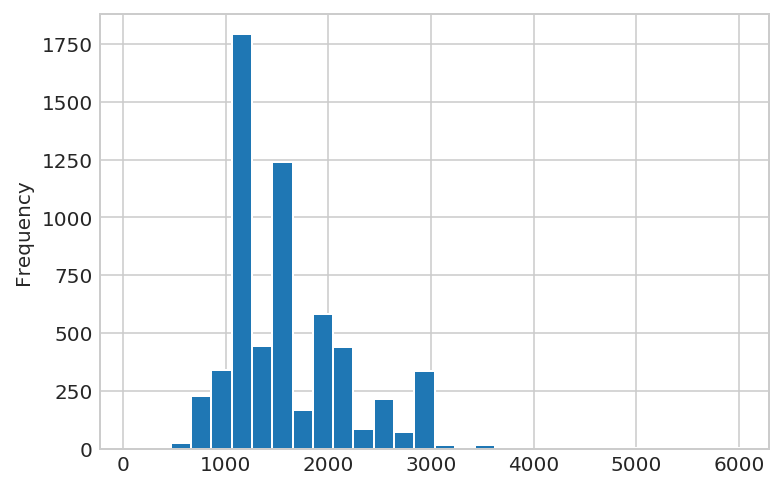

In [19]:
cars['engine'].plot(kind='hist',bins=30)
plt.show()

In [20]:
len(cars[cars['engine'].isnull()])

0

___

## Dealing with anomalous values in "mileage" column

In [21]:
len(cars[cars['mileage'].isnull()])

2

In [22]:
cars[cars['mileage'].isnull()]

,name,city,year,kms,fuel,transmission,owner,mileage,engine,power,seats,price,brand,model
4446,Mahindra E Verito D4,Chennai,2016,50000,Electric,Automatic,First,NaN,72,41 bhp,5.0,13.00,Mahindra,E
4904,Toyota Prius 2009-2016 Z4,Mumbai,2011,44000,Electric,Automatic,First,NaN,1798,73 bhp,5.0,12.75,Toyota,Prius


In [23]:
cars.loc[cars["model"]=="Prius","mileage"]=24
cars.loc[cars["model"]=="E","mileage"]=30

In [24]:
for i in range(len(cars)):
    st=cars.loc[i,"mileage"]
    #print(i)
    a=4
    if type(st)!=type(a):
    #print(st)
    #st=str(st)
        le=""
        for j in st:
            if j==' ':
                break
            le=le+j
        cars.loc[i,"mileage"]=le

In [25]:
cars["mileage"]=pd.to_numeric(cars["mileage"])

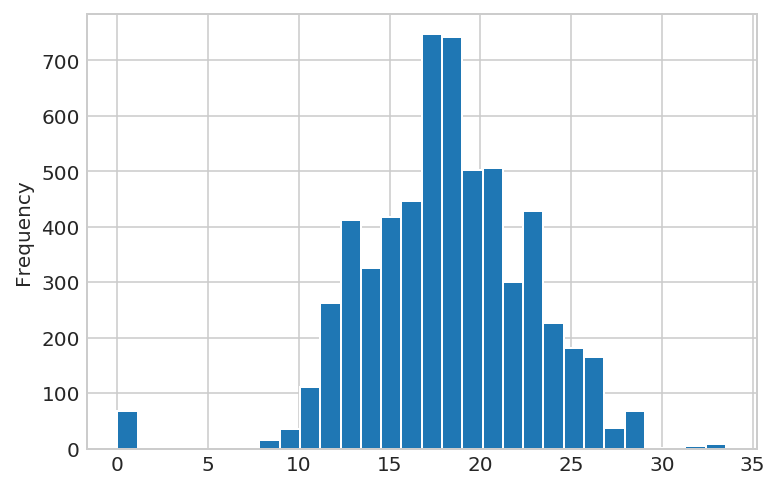

In [26]:
cars['mileage'].plot(kind='hist',bins=30)
plt.show()

In [27]:
len(cars[cars['mileage'].isnull()])

0

### Dealing with cars which are supposed to have zero mileage ( which obviously signifies faulty data collection)

In [28]:
cars[cars["mileage"]<5]

,name,city,year,kms,fuel,transmission,owner,mileage,engine,power,seats,price,brand,model
14,Land Rover Freelander 2 TD4 SE,Pune,2012,85000,Diesel,Automatic,Second,0.0,2179,115 bhp,5.0,17.50,Land_Rover,Rover
67,Mercedes-Benz C-Class Progressive C 220d,Coimbatore,2019,15369,Diesel,Automatic,First,0.0,1950,194 bhp,5.0,35.67,Mercedes-Benz,C-Class
79,Hyundai Santro Xing XL,Hyderabad,2005,87591,Petrol,Manual,First,0.0,1086,null bhp,5.0,1.30,Hyundai,Santro
194,Honda City 1.5 GXI,Ahmedabad,2007,60006,Petrol,Manual,First,0.0,1500,NaN,NaN,2.95,Honda,City
229,Ford Figo Diesel,Bangalore,2015,70436,Diesel,Manual,First,0.0,1498,99 bhp,NaN,3.60,Ford,Figo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5647,Toyota Qualis Fleet A3,Mumbai,2001,227000,Diesel,Manual,Fourth & Above,0.0,2446,null bhp,8.0,2.20,Toyota,Qualis
5875,Mercedes-Benz C-Class Progressive C 220d,Ahmedabad,2019,4000,Diesel,Automatic,First,0.0,1950,194 bhp,5.0,35.00,Mercedes-Benz,C-Class
5943,Mahindra Jeep MM 540 DP,Chennai,2002,75000,Diesel,Manual,First,0.0,2112,null bhp,6.0,1.70,Mahindra,Jeep
5972,Hyundai Santro Xing GL,Mumbai,2008,65000,Petrol,Manual,Second,0.0,1086,62 bhp,5.0,1.39,Hyundai,Santro


In [29]:
#cars.loc[(cars['model'] == 'New') & (cars['brand'] == 'Mercedes-Benz'), 'model'] = 'C-Class'
#cars[cars['engine'].isnull()].loc[cars["model"]=="Swift","engine"]=1300
#print(le)
col_name="mileage"
cars.loc[i,col_name]
for i in range(len(cars)):
    if cars[col_name][i]==0:
        if cars["model"][i]=="Santro":
            cars.loc[i,col_name]=17
        elif cars["model"][i]=="Jeep":
            cars.loc[i,col_name]=12
        elif cars["model"][i]=="Qualis":
            cars.loc[i,col_name]=13.1
        elif cars["model"][i]=="Jetta":
            cars.loc[i,col_name]=17
        elif cars["model"][i]=="Qualis":
            cars.loc[i,col_name]=13.1
        elif cars["model"][i]=="C-Class":
            cars.loc[i,col_name]=15.07
        elif cars["model"][i]=="Superb":
            cars.loc[i,col_name]=13.9
        elif cars["model"][i]=="M-Class":
            cars.loc[i,col_name]=11.74
        elif cars["model"][i]=="Rover":
            cars.loc[i,col_name]=12.70
        elif cars["model"][i]=="City":
            if cars["fuel"][i]=="Petrol":
                cars.loc[i,col_name]=16.72
            else:
                cars.loc[i,col_name]=25.68
        elif cars["model"][i]=="Figo":
            cars.loc[i,col_name]=20.8
        elif cars["model"][i]=="A7":
            cars.loc[i,col_name]=14.4
        elif cars["model"][i]=="Baleno":
            cars.loc[i,col_name]=21.4
        elif cars["model"][i]=="A7":
            cars.loc[i,col_name]=14.4
        elif cars["model"][i]=="Siena":
            cars.loc[i,col_name]=12
        elif cars["model"][i]=="Fortwo":
            cars.loc[i,col_name]=55*0.43
        #cars[col_name][i]=str(cars[col_name][i])

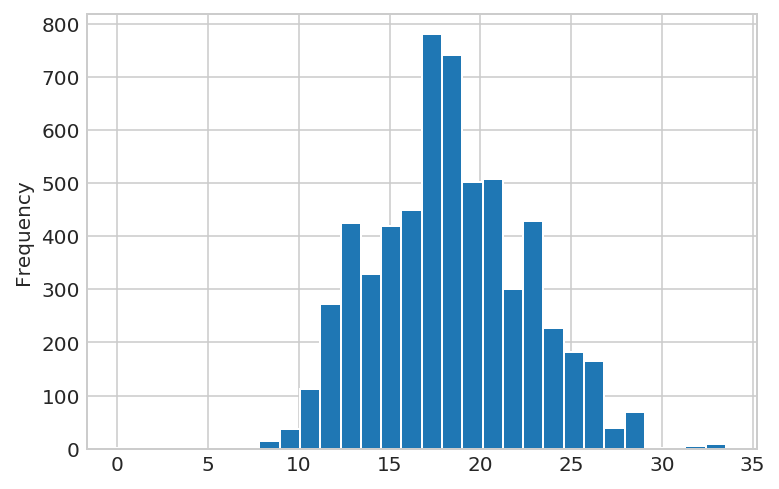

In [30]:
cars['mileage'].plot(kind='hist',bins=30)
plt.show()

___

## Dealing with "seats" column

In [31]:
len(cars[cars['seats'].isnull()])

42

In [32]:
cars[cars['seats'].isnull()].head()

,name,city,year,kms,fuel,transmission,owner,mileage,engine,power,seats,price,brand,model
194,Honda City 1.5 GXI,Ahmedabad,2007,60006,Petrol,Manual,First,16.72,1500,NaN,NaN,2.95,Honda,City
208,Maruti Swift 1.3 VXi,Kolkata,2010,42001,Petrol,Manual,First,16.10,1300,NaN,NaN,2.11,Maruti,Swift
229,Ford Figo Diesel,Bangalore,2015,70436,Diesel,Manual,First,20.80,1498,99 bhp,NaN,3.60,Ford,Figo
733,Maruti Swift 1.3 VXi,Chennai,2006,97800,Petrol,Manual,Third,16.10,1300,NaN,NaN,1.75,Maruti,Swift
749,Land Rover Range Rover 3.0 D,Mumbai,2008,55001,Diesel,Automatic,Second,12.70,3000,NaN,NaN,26.50,Land_Rover,Rover


In [33]:
five=["Santro","Punto","Swift","City","Jazz","Estilo","Etios","Figo","Wagon-R","5","Rover","CR-V"]

### Manual handling of null values ( data derived from cardekho.com)

In [34]:
#cars.loc[(cars['model'] == 'New') & (cars['brand'] == 'Mercedes-Benz'), 'model'] = 'C-Class'
#cars[cars['engine'].isnull()].loc[cars["model"]=="Swift","engine"]=1300
le=cars["seats"].isnull()
#print(le)
col_name="seats"
for i in range(len(cars)):
    if le[i]==True:
        if cars["model"][i]in five:
            cars.loc[i,"seats"]=5
        else:
            cars.loc[i,"seats"]=7

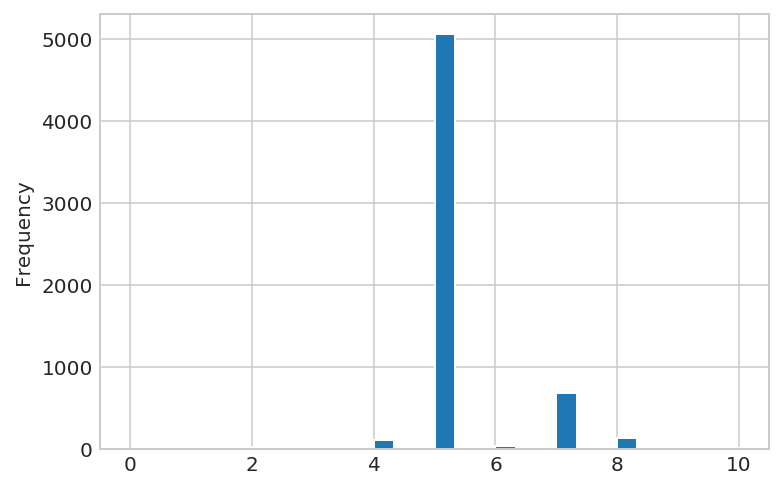

In [35]:
cars['seats'].plot(kind='hist',bins=30)
plt.show()

In [36]:
len(cars[cars['seats'].isnull()])

0

# -------------------------------------------------------------------------------------------------------------

# Dealing with "power" column

In [37]:
len(cars[cars['power'].isnull()])

36

In [38]:
cars[cars['power'].isnull()]

,name,city,year,kms,fuel,transmission,owner,mileage,engine,power,seats,price,brand,model
194,Honda City 1.5 GXI,Ahmedabad,2007,60006,Petrol,Manual,First,16.72,1500,NaN,5.0,2.95,Honda,City
208,Maruti Swift 1.3 VXi,Kolkata,2010,42001,Petrol,Manual,First,16.10,1300,NaN,5.0,2.11,Maruti,Swift
733,Maruti Swift 1.3 VXi,Chennai,2006,97800,Petrol,Manual,Third,16.10,1300,NaN,5.0,1.75,Maruti,Swift
749,Land Rover Range Rover 3.0 D,Mumbai,2008,55001,Diesel,Automatic,Second,12.70,3000,NaN,5.0,26.50,Land_Rover,Rover
1294,Honda City 1.3 DX,Delhi,2009,55005,Petrol,Manual,First,12.80,1500,NaN,5.0,3.20,Honda,City
1327,Maruti Swift 1.3 ZXI,Hyderabad,2015,50295,Petrol,Manual,First,16.10,1300,NaN,5.0,5.80,Maruti,Swift
1385,Honda City 1.5 GXI,Pune,2004,115000,Petrol,Manual,Second,16.72,1500,NaN,5.0,1.50,Honda,City
1460,Land Rover Range Rover Sport 2005 2012 Sport,Coimbatore,2008,69078,Petrol,Manual,First,12.70,3000,NaN,5.0,40.88,Land_Rover,Rover
2074,Maruti Swift 1.3 LXI,Pune,2011,24255,Petrol,Manual,First,16.10,1300,NaN,5.0,3.15,Maruti,Swift
2096,Hyundai Santro LP zipPlus,Coimbatore,2004,52146,Petrol,Manual,First,17.00,1086,NaN,5.0,1.93,Hyundai,Santro


## Manual handling of null values ( data derived from cardekho.com)

In [39]:
#cars.loc[(cars['model'] == 'New') & (cars['brand'] == 'Mercedes-Benz'), 'model'] = 'C-Class'
#cars[cars['engine'].isnull()].loc[cars["model"]=="Swift","engine"]=1300
le=cars["power"].isnull()
#print(le)
col_name="power"
cars.loc[76,col_name]=67
cars.loc[79,col_name]=62

for i in range(len(cars)):
    if le[i]==True or cars.loc[i,"power"]=='null':
        if cars["model"][i]=="Swift":
            cars.loc[i,col_name]=75
        elif cars["model"][i]=="City":
            if cars["fuel"][i]=="Petrol":
                cars.loc[i,col_name]=117.3
            else:
                cars.loc[i,col_name]=98.6
        elif cars["model"][i]=="Santro":
            cars.loc[i,col_name]=62          
        elif cars["model"][i]=="Jazz":
            if cars["fuel"][i]=="Petrol":
                cars.loc[i,col_name]=88.7
            else:
                cars[col_name][i]=98.6
        elif cars["model"][i]=="Punto":
            cars.loc[i,col_name]=67
        elif cars["model"][i]=="5":
            cars.loc[i,col_name]=200
        elif cars["model"][i]=="Etios":
            cars.loc[i,col_name]=78.9
        elif cars["model"][i]=="Wagon-R" or cars["model"][i]=='Wagon':
            cars.loc[i,col_name]=67.1
        elif cars["model"][i]=="CR-V":
            cars.loc[i,col_name]=152
        elif cars["name"][i]=="Land Rover Range Rover 3.0 D":
            cars.loc[i,col_name]=255
        elif cars["model"][i]=="Rover":
            cars.loc[i,col_name]=503
        elif cars["model"][i]=="Estilo":
            cars.loc[i,col_name]=68
        elif cars["model"][i]=="Qualis":
            cars.loc[i,col_name]=75
        elif cars["model"][i]=="E-Class":
            cars.loc[i,col_name]=192
        elif cars["model"][i]=="Esteem":
            cars.loc[i,col_name]=85
        elif cars["model"][i]=="Indica":
            cars.loc[i,col_name]=69
        elif cars["model"][i]=="Jeep":
            cars.loc[i,col_name]=62
        elif cars["model"][i]=="Petra":
            cars.loc[i,col_name]=72
        elif cars["model"][i]=="100":
            cars.loc[i,col_name]=37
        elif cars["model"][i]=="Cayman":
            cars.loc[i,col_name]=320
        elif cars["model"][i]=="Laura":
            cars.loc[i,col_name]=160
        elif cars["model"][i]=="Optra":
            cars.loc[i,col_name]=110
        elif cars["model"][i]=="A4":
            cars.loc[i,col_name]=265
        elif cars["model"][i]=="Jetta":
            cars.loc[i,col_name]=105
        elif cars["model"][i]=="Micra":
            cars.loc[i,col_name]=63.1
        elif cars["model"][i]=="1000":
            cars.loc[i,col_name]=32
        elif cars["model"][i]=="Bolero":
            cars.loc[i,col_name]=63
        elif cars["model"][i]=="Siena":
            cars.loc[i,col_name]=45
        elif cars["model"][i]=="Teana":
            cars.loc[i,col_name]=179.5
        elif cars["name"][i]=="Ford Endeavour Hurricane LE":
            cars.loc[i,col_name]=156
        elif cars["model"][i]=="Endeavour":
            cars.loc[i,col_name]=141
        elif cars["model"][i]=="Fortwo":
            cars.loc[i,col_name]=85
        else:
            cars.loc[i,col_name]=80

In [40]:
col_name="power"
for i in range(len(cars)):
    st=cars["power"][i]
    a=4.1
    b=3
    if type(st)!=type(a) and type(st)!=type(b):
        le=""
        for j in st:
            if j==' ':
                break
            le=le+j
        cars.loc[i,col_name]=le

In [41]:
#cars.loc[(cars['model'] == 'New') & (cars['brand'] == 'Mercedes-Benz'), 'model'] = 'C-Class'
#cars[cars['engine'].isnull()].loc[cars["model"]=="Swift","engine"]=1300
le=cars["power"].isnull()
#print(le)
col_name="power"
cars.loc[76,col_name]=67
cars.loc[79,col_name]=62

for i in range(len(cars)):
    if le[i]==True or cars.loc[i,"power"]=='null':
        if cars["model"][i]=="Swift":
            cars.loc[i,col_name]=75
        elif cars["model"][i]=="City":
            if cars["fuel"][i]=="Petrol":
                cars.loc[i,col_name]=117.3
            else:
                cars.loc[i,col_name]=98.6
        elif cars["model"][i]=="Santro":
            cars.loc[i,col_name]=62          
        elif cars["model"][i]=="Jazz":
            if cars["fuel"][i]=="Petrol":
                cars.loc[i,col_name]=88.7
            else:
                cars[col_name][i]=98.6
        elif cars["model"][i]=="Punto":
            cars.loc[i,col_name]=67
        elif cars["model"][i]=="5":
            cars.loc[i,col_name]=200
        elif cars["model"][i]=="Etios":
            cars.loc[i,col_name]=78.9
        elif cars["model"][i]=="Wagon-R" or cars["model"][i]=='Wagon':
            cars.loc[i,col_name]=67.1
        elif cars["model"][i]=="CR-V":
            cars.loc[i,col_name]=152
        elif cars["name"][i]=="Land Rover Range Rover 3.0 D":
            cars.loc[i,col_name]=255
        elif cars["model"][i]=="Rover":
            cars.loc[i,col_name]=503
        elif cars["model"][i]=="Estilo":
            cars.loc[i,col_name]=68
        elif cars["model"][i]=="Qualis":
            cars.loc[i,col_name]=75
        elif cars["model"][i]=="E-Class":
            cars.loc[i,col_name]=192
        elif cars["model"][i]=="Esteem":
            cars.loc[i,col_name]=85
        elif cars["model"][i]=="Indica":
            cars.loc[i,col_name]=69
        elif cars["model"][i]=="Jeep":
            cars.loc[i,col_name]=62
        elif cars["model"][i]=="Petra":
            cars.loc[i,col_name]=72
        elif cars["model"][i]=="100":
            cars.loc[i,col_name]=37
        elif cars["model"][i]=="Cayman":
            cars.loc[i,col_name]=320
        elif cars["model"][i]=="Laura":
            cars.loc[i,col_name]=160
        elif cars["model"][i]=="Optra":
            cars.loc[i,col_name]=110
        elif cars["model"][i]=="A4":
            cars.loc[i,col_name]=265
        elif cars["model"][i]=="Jetta":
            cars.loc[i,col_name]=105
        elif cars["model"][i]=="Micra":
            cars.loc[i,col_name]=63.1
        elif cars["model"][i]=="1000":
            cars.loc[i,col_name]=32
        elif cars["model"][i]=="Bolero":
            cars.loc[i,col_name]=63
        elif cars["model"][i]=="Siena":
            cars.loc[i,col_name]=45
        elif cars["model"][i]=="Teana":
            cars.loc[i,col_name]=179.5
        elif cars["name"][i]=="Ford Endeavour Hurricane LE":
            cars.loc[i,col_name]=156
        elif cars["model"][i]=="Endeavour":
            cars.loc[i,col_name]=141
        elif cars["model"][i]=="Fortwo":
            cars.loc[i,col_name]=85
        else:
            cars.loc[i,col_name]=80
            
col_name="power"
for i in range(len(cars)):
    st=cars["power"][i]
    a=4.1
    b=3
    if type(st)!=type(a) and type(st)!=type(b):
        le=""
        for j in st:
            if j==' ':
                break
            le=le+j
        cars.loc[i,col_name]=le

In [42]:
cars["power"]=pd.to_numeric(cars["power"])

## There seems to be a high correlation between engine and power
Hence, it seems fair to drop one of the columns ( let's say the power column). Even though it analytically does not seem to matter to the Random Forest Algorithm whether two columns are correlated or not, we will drop the "power: column anyway for sake of simplicity.

In [43]:
cars.corr()

,year,kms,mileage,engine,power,seats,price
year,1.000000,-0.173048,0.295254,-0.050621,0.031420,0.013465,0.305327
kms,-0.173048,1.000000,-0.064611,0.090577,0.030449,0.083675,-0.011493
mileage,0.295254,-0.064611,1.000000,-0.643276,-0.544305,-0.340743,-0.336008
engine,-0.050621,0.090577,-0.643276,1.000000,0.864576,0.392469,0.659314
power,0.031420,0.030449,-0.544305,0.864576,1.000000,0.092668,0.772950
seats,0.013465,0.083675,-0.340743,0.392469,0.092668,1.000000,0.052358
price,0.305327,-0.011493,-0.336008,0.659314,0.772950,0.052358,1.000000


---

## Viewing the unique value of all the columns along with frequency count

In [44]:
for i in cars.columns:
    print("Number of unique values for {} is {}".format(i,len(cars[i].unique())))

Number of unique values for name is 1876
Number of unique values for city is 11
Number of unique values for year is 22
Number of unique values for kms is 3093
Number of unique values for fuel is 5
Number of unique values for transmission is 2
Number of unique values for owner is 4
Number of unique values for mileage is 434
Number of unique values for engine is 150
Number of unique values for power is 372
Number of unique values for seats is 9
Number of unique values for price is 1373
Number of unique values for brand is 30
Number of unique values for model is 212


# ---------------------------------------------------------------------------------------------------------

## Distribution of data vs "Model year"
The graph plotted here shows that the recent years have more listings than the earlier ones. There can be two possible explanations:
* In the 90s and early 2000s, data collection was not rigorous.
* The cars which are old are less likely to attract potential buyers and have very less probability of being sold.

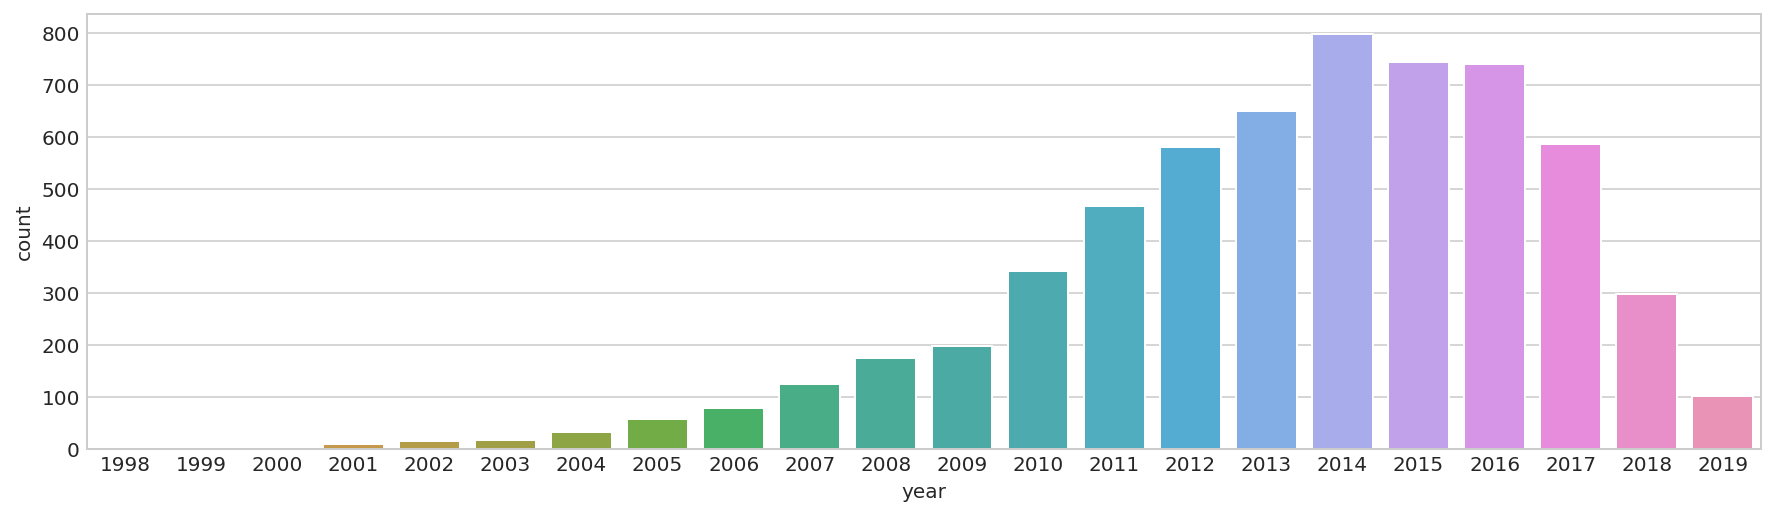

In [45]:
#The purpose of using plt.figure() is to create a figure object.
fig = plt.figure(figsize=(15,4))
sns.countplot(x="year", data=cars)

## Distibution of kms driven

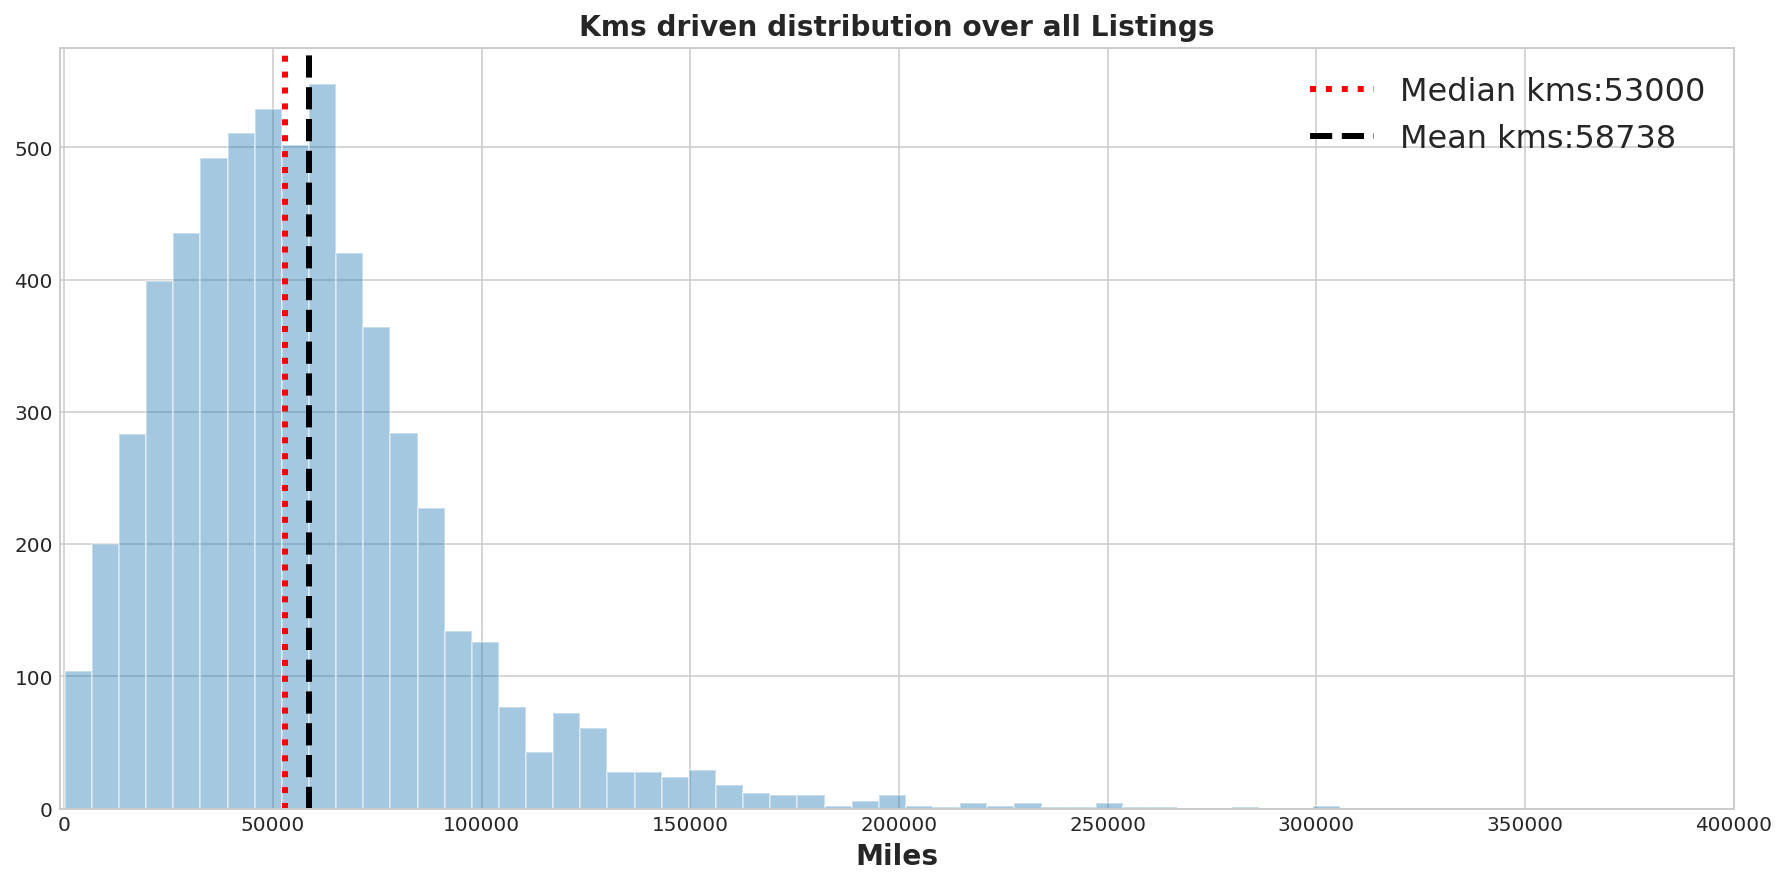

In [46]:
# look at miles overall distribution
fig = plt.figure(figsize=(15,7))
ax = fig.gca()
sns.distplot(cars["kms"],kde=False,bins=1000)
plt.xlabel('Miles',fontsize=14,fontweight="bold")
plt.axvline(cars["kms"].median(),lw=3,ls='dotted',
            color='red',label='Median kms:'+'{0:.0f}'.format(np.median(cars["kms"])))
plt.axvline(cars["kms"].mean(),lw=3,ls='dashed',
            color='black',label='Mean kms:'+'{0:.0f}'.format(np.mean(cars["kms"])))
plt.title('Kms driven distribution over all Listings',fontsize=14,fontweight="bold")
plt.legend(loc='upper right',fontsize=16)
plt.xlim(-1000,400000)
plt.show()

## Distribution of kms per year. Showing boxplot to get a better feel for the ranges and possible outliers.
The figure conforms with our intuition that the cars which were purchased earlier are likely to have covered much more ground than the later ones.



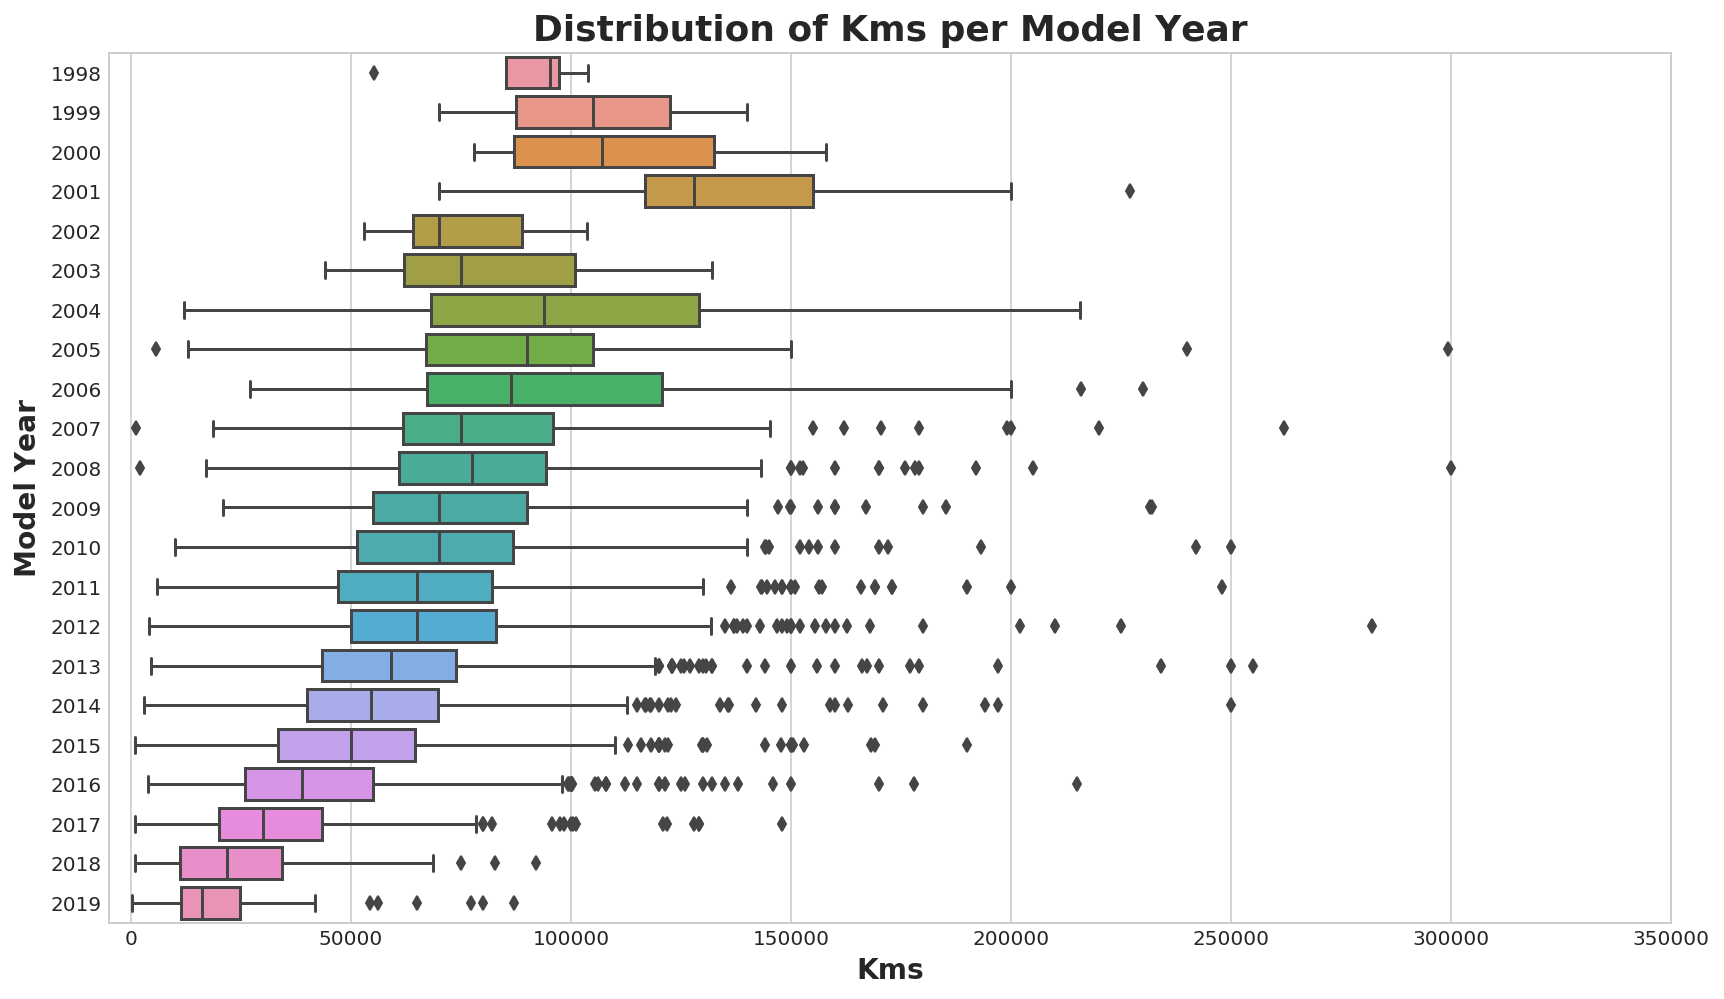

In [47]:
# look at miles by year boxplot
fig = plt.figure(figsize=(14,8))
ax = fig.gca()
sns.boxplot(x='kms',y='year',data=cars,orient='h')
plt.xlabel('Kms',fontsize=14,fontweight="bold")
ax.set_yticklabels(sorted(cars["year"].unique()))
plt.ylabel('Model Year',fontsize=14,fontweight="bold")
plt.title('Distribution of Kms per Model Year',fontsize=18,fontweight="bold")
plt.xlim(-5000,350000)
plt.show()

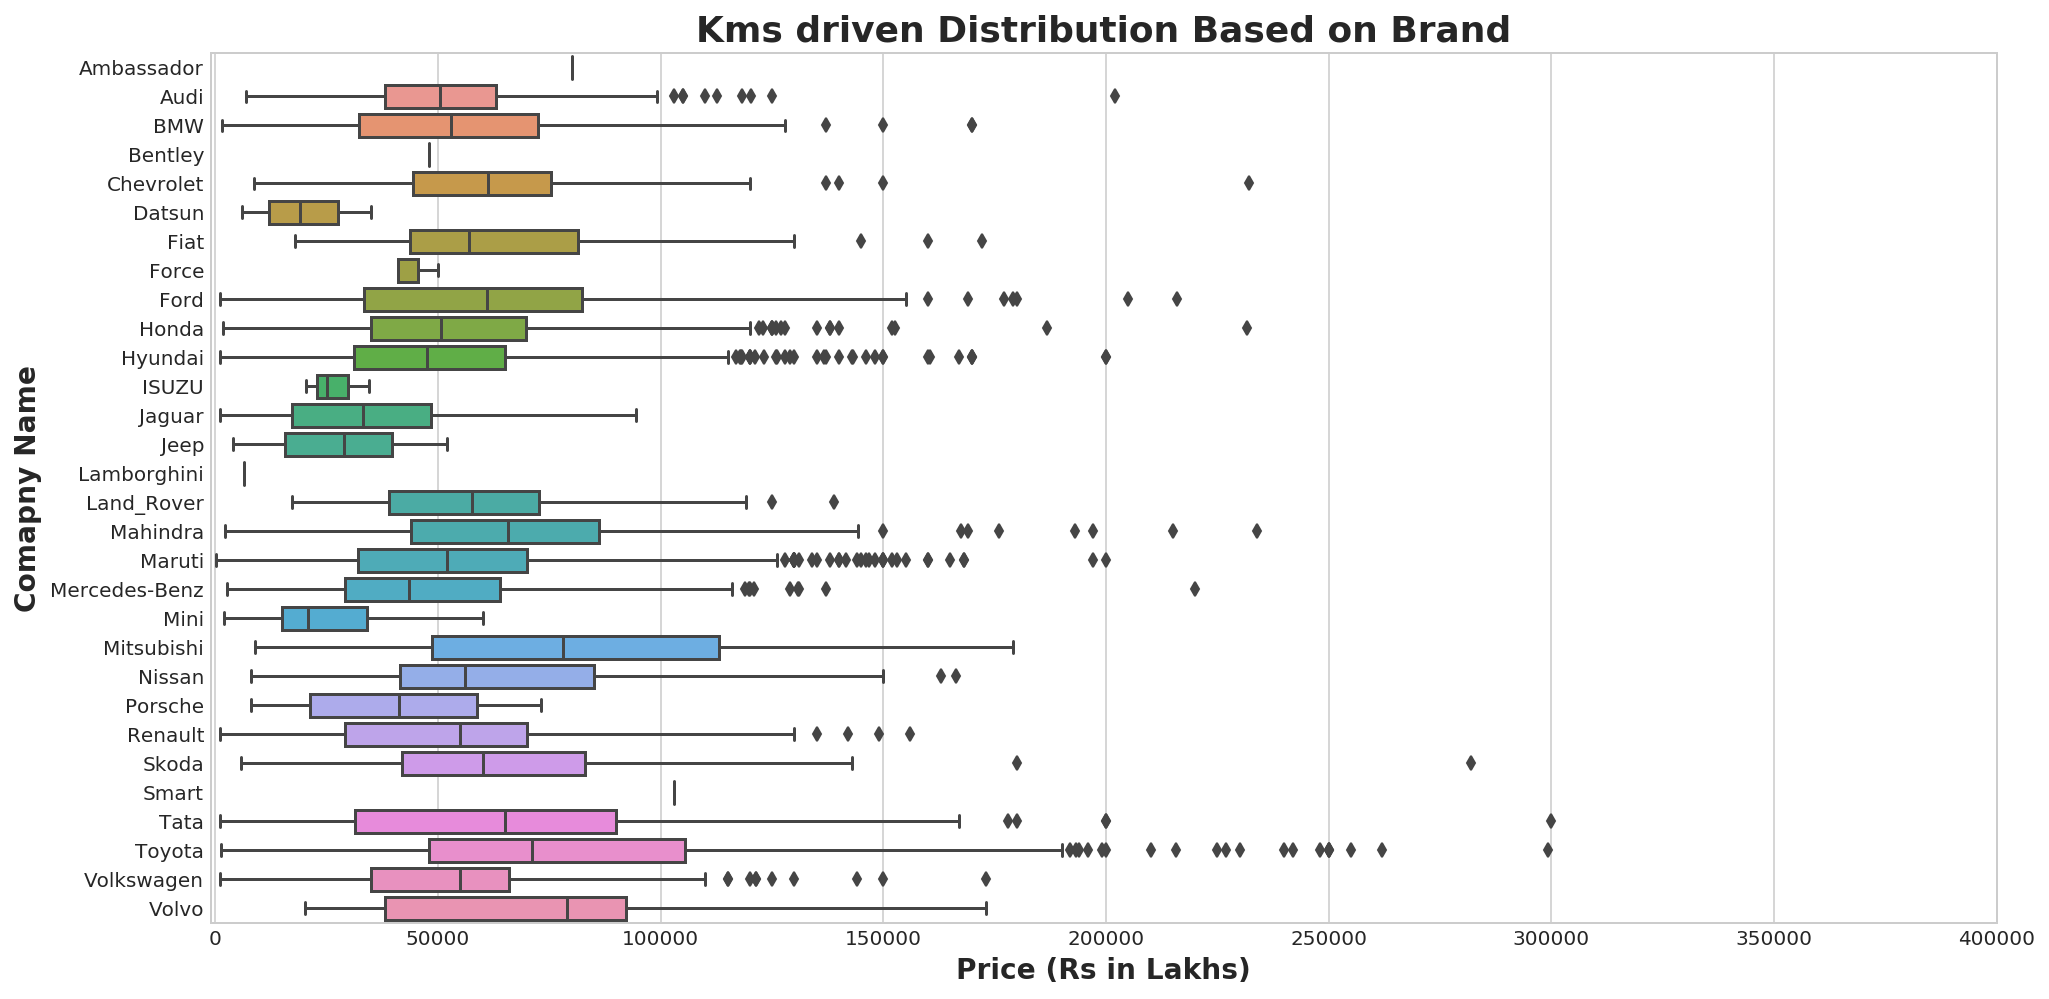

In [48]:
# look at kms by BRAND boxplot
# limit upper prices so it's more informative

fig = plt.figure(figsize=(16,8))
ax = fig.gca()
sns.boxplot(x='kms',y='brand',data=cars,
            order=sorted(cars["brand"].unique()),orient='h')
plt.xlabel('Price (Rs in Lakhs)',fontsize=14,fontweight="bold")
plt.ylabel('Comapny Name',fontsize=14,fontweight="bold")
plt.title('Kms driven Distribution Based on Brand',fontsize=18,fontweight="bold")
plt.xlim(-1000,400000)
plt.show()

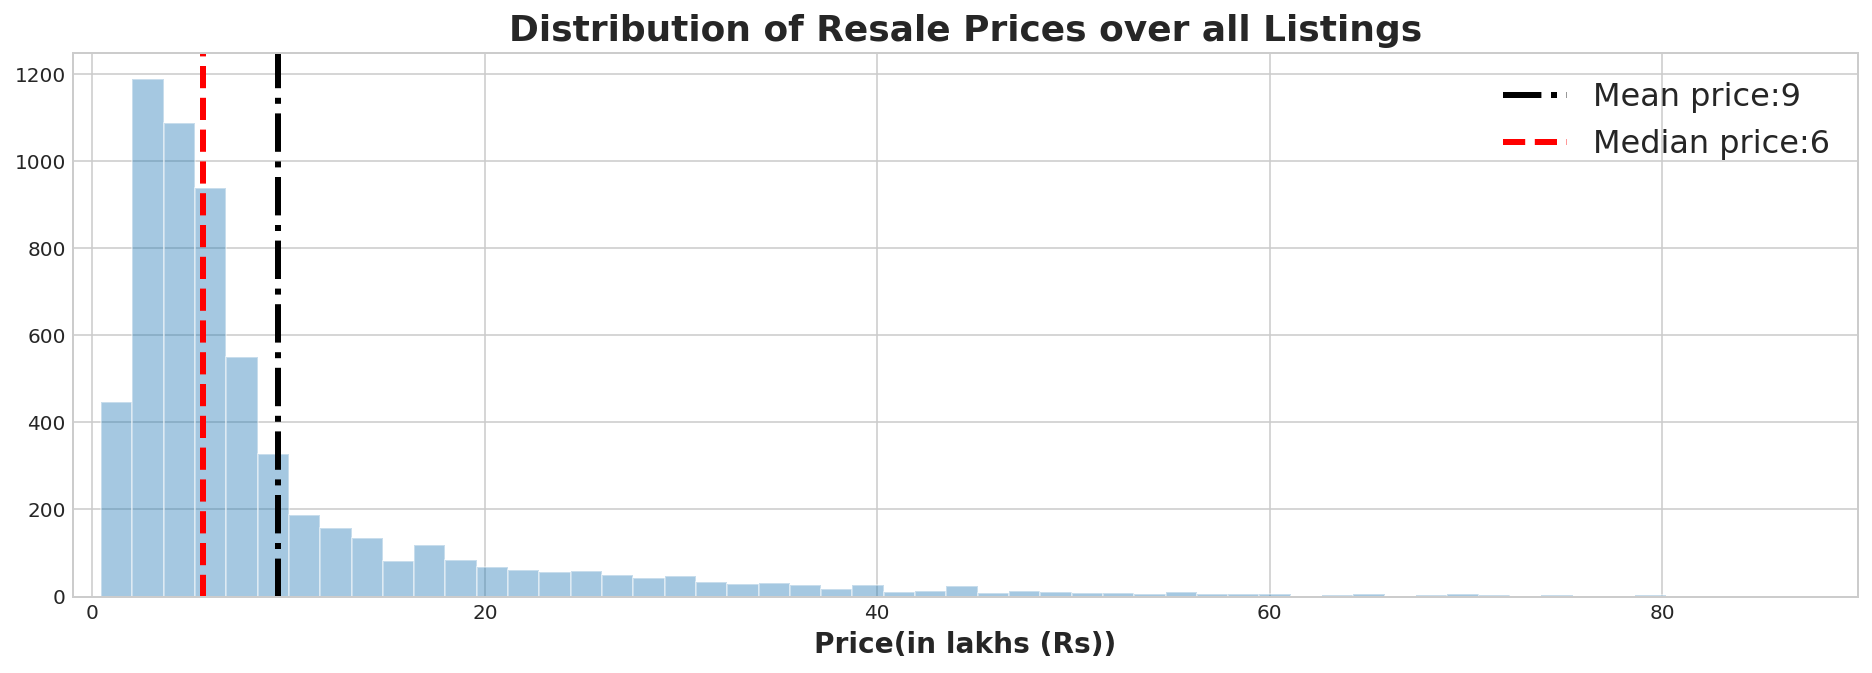

In [49]:
# look at price distribution
fig = plt.figure(figsize=(16,5))
ax = fig.gca()
sns.distplot(cars["price"],kde=False,bins=100)
plt.xlabel('Price(in lakhs (Rs))',fontsize=14,fontweight="bold")
plt.axvline(cars["price"].mean(),lw=3,ls='dashdot',
            color='black',label='Mean price:'+'{0:.0f}'.format(np.mean(cars["price"])))
plt.axvline(cars["price"].median(),lw=3,ls='dashed',
            color='red',label='Median price:'+'{0:.0f}'.format(np.median(cars["price"])))
plt.title('Distribution of Resale Prices over all Listings',fontsize=18,fontweight="bold")
plt.legend(loc='upper right',fontsize=16)
plt.xlim(-1,90)
plt.show()

## Price based on Model Year
> The trend in the graph is quite clear : the cars of recent years sell for a much higher price.

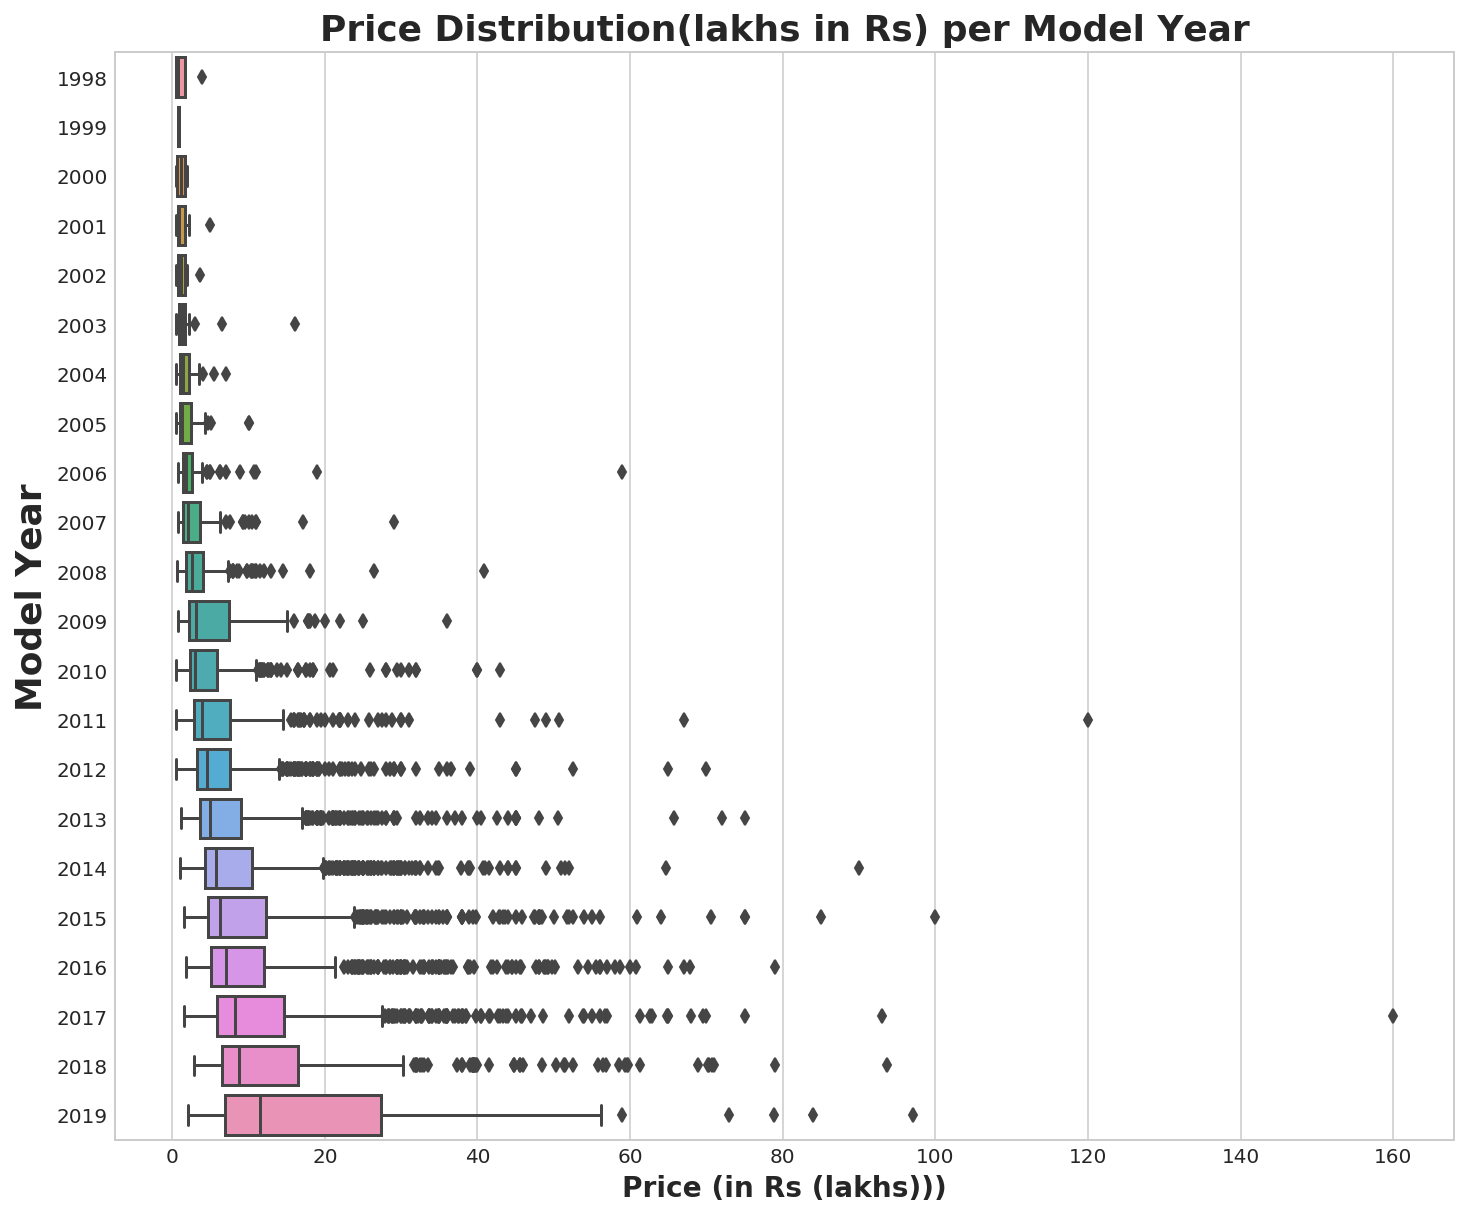

In [50]:
# look at price by year boxplot
# limit upper prices so it's more informative
fig = plt.figure(figsize=(12,10))
ax = fig.gca()
sns.boxplot(x='price',y='year',data=cars,
            order=sorted(cars["year"].unique()),orient='h')
plt.xlabel('Price (in Rs (lakhs)))',fontsize=14,fontweight="bold")
#ax.set_yticklabels(sorted(cc_data.modelYear.unique()))
plt.ylabel('Model Year',fontsize=18,fontweight="bold")
plt.title('Price Distribution(lakhs in Rs) per Model Year',fontsize=18,fontweight="bold")
plt.show()

## Price based on Brand
We can infer that in the Indian market, there are some premium car brands like BMW, Audi, Porsche etc, whose cars have a higher selling value as compared to other brands like Maruti Suzuki, Hyundai ,Toyota etc.

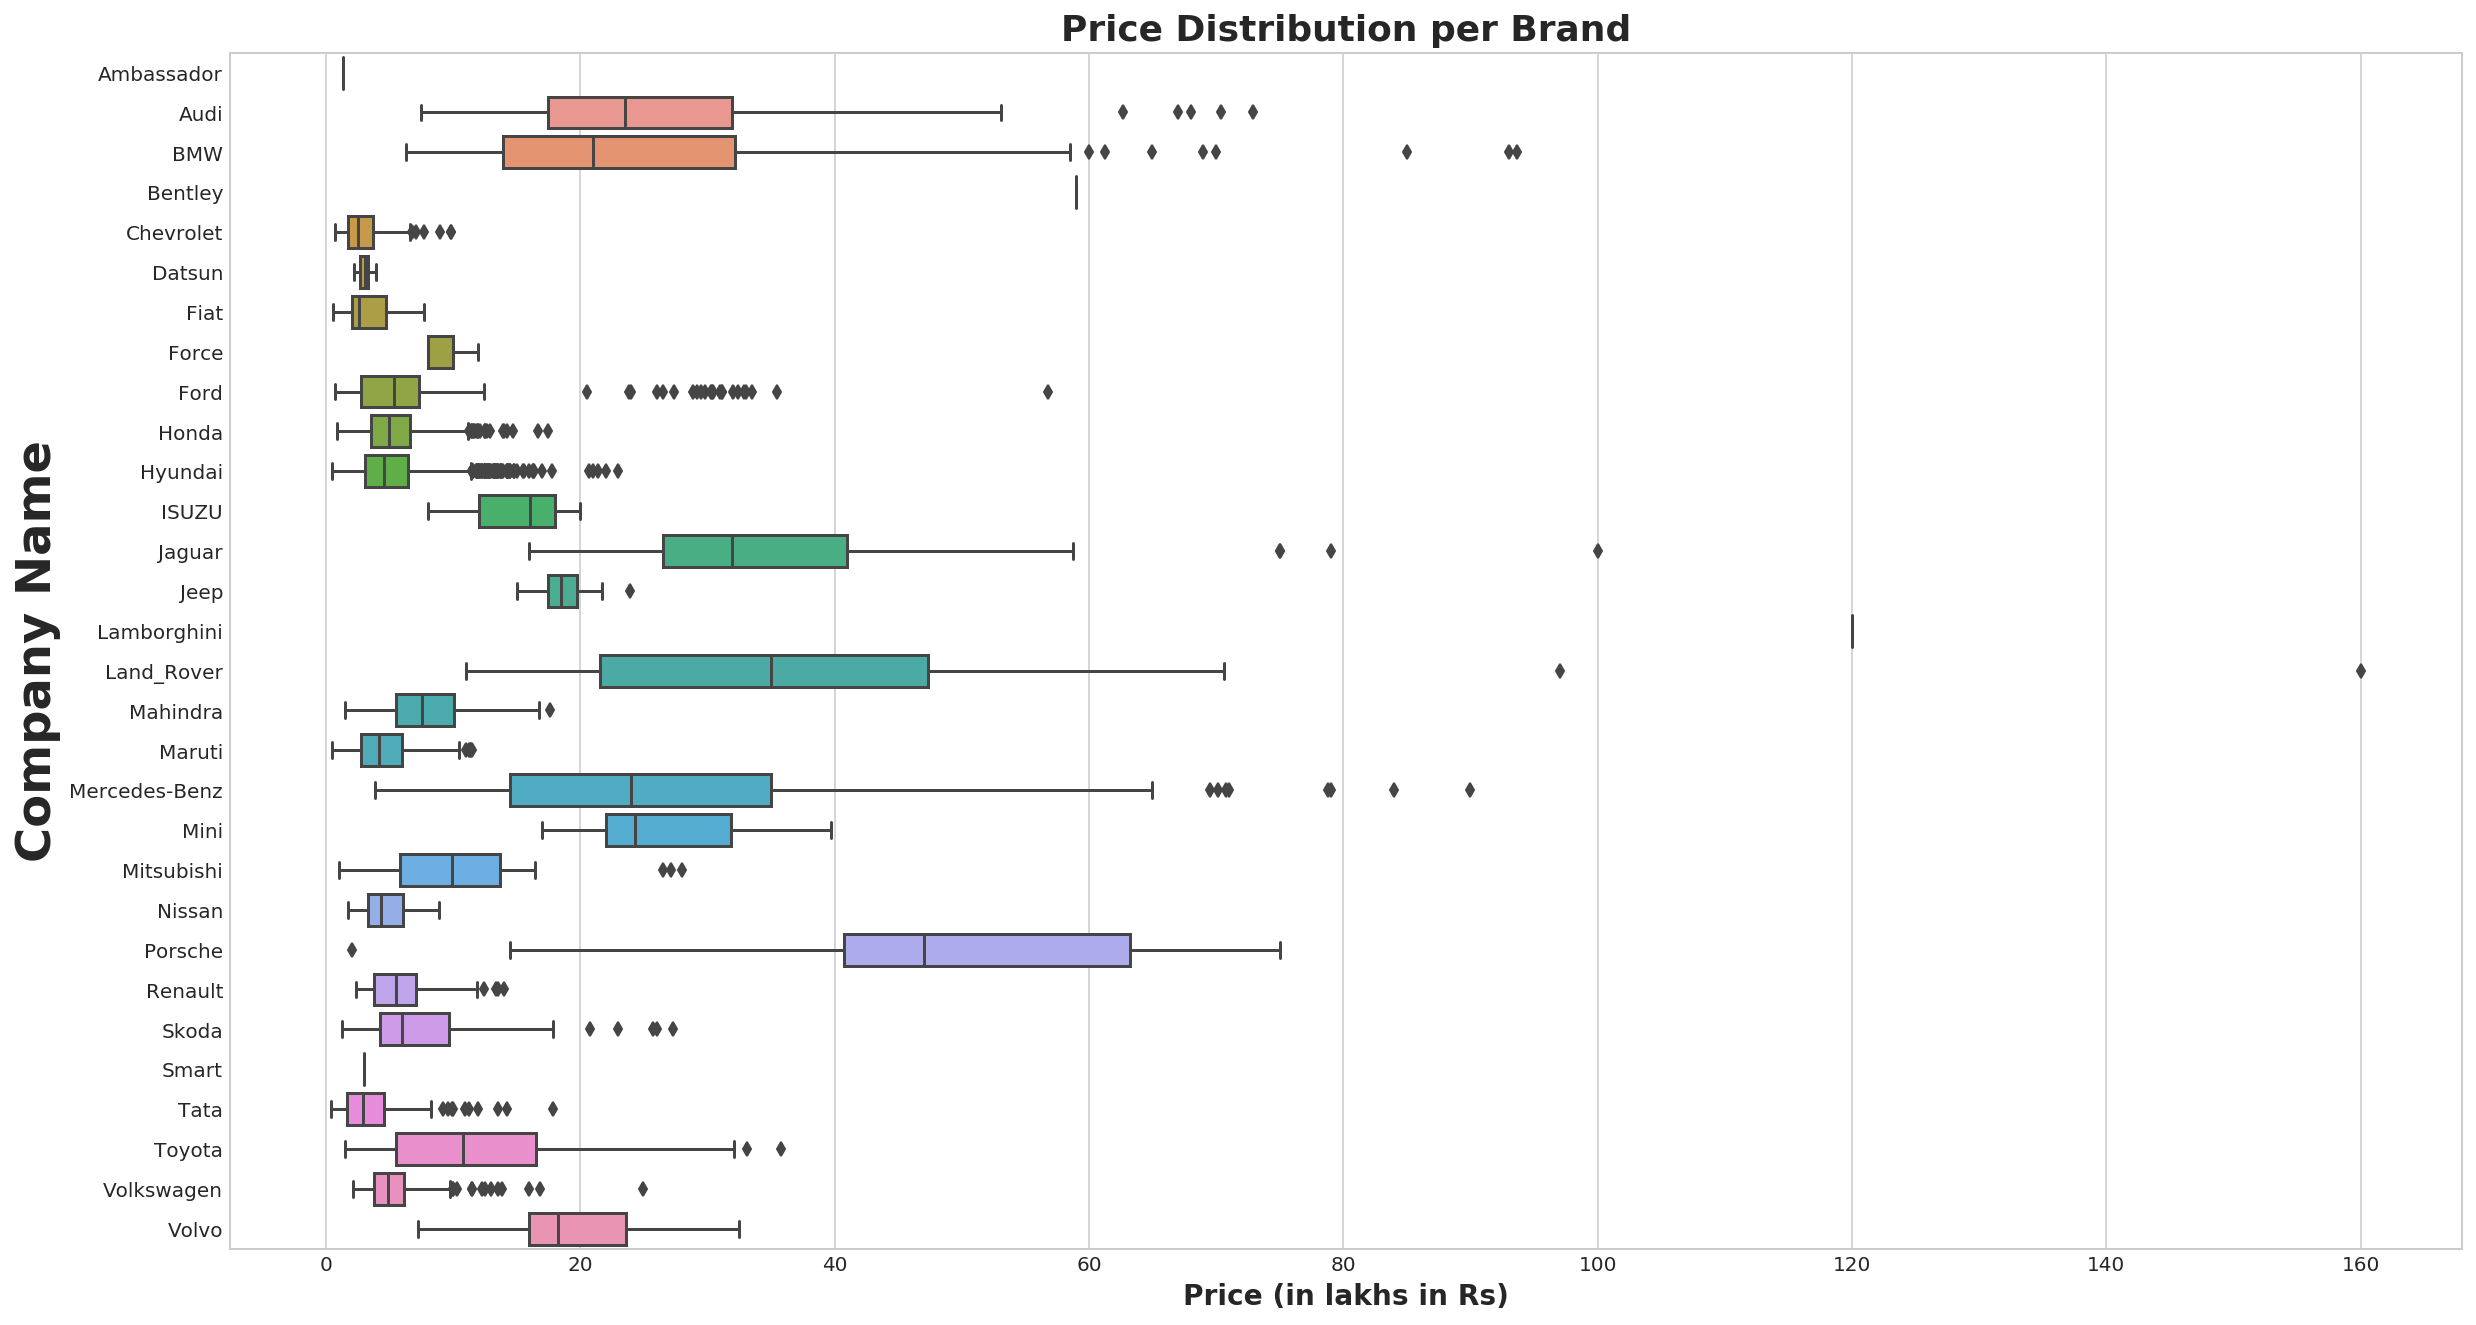

In [51]:
# limit upper prices so it's more informative
fig = plt.figure(figsize=(20,11))
ax = fig.gca()
sns.boxplot(x='price',y='brand',data=cars,
            order=sorted(cars["brand"].unique()),orient='h')
plt.xlabel('Price (in lakhs in Rs)',fontsize=14,fontweight="bold")
plt.ylabel('Company Name',fontsize=24,fontweight="bold")
plt.title('Price Distribution per Brand',fontsize=18,fontweight="bold")
plt.show()

The plot above shows that even with a specific make, there can be very large price variations. Not too surprising when you consider that many brands have a 'flagship vehicle' that is sold at a high price and in very small numbers.

## Number of listings vs City plot
The city where a car is being sold does not happen to have too much effect on the price of a car.

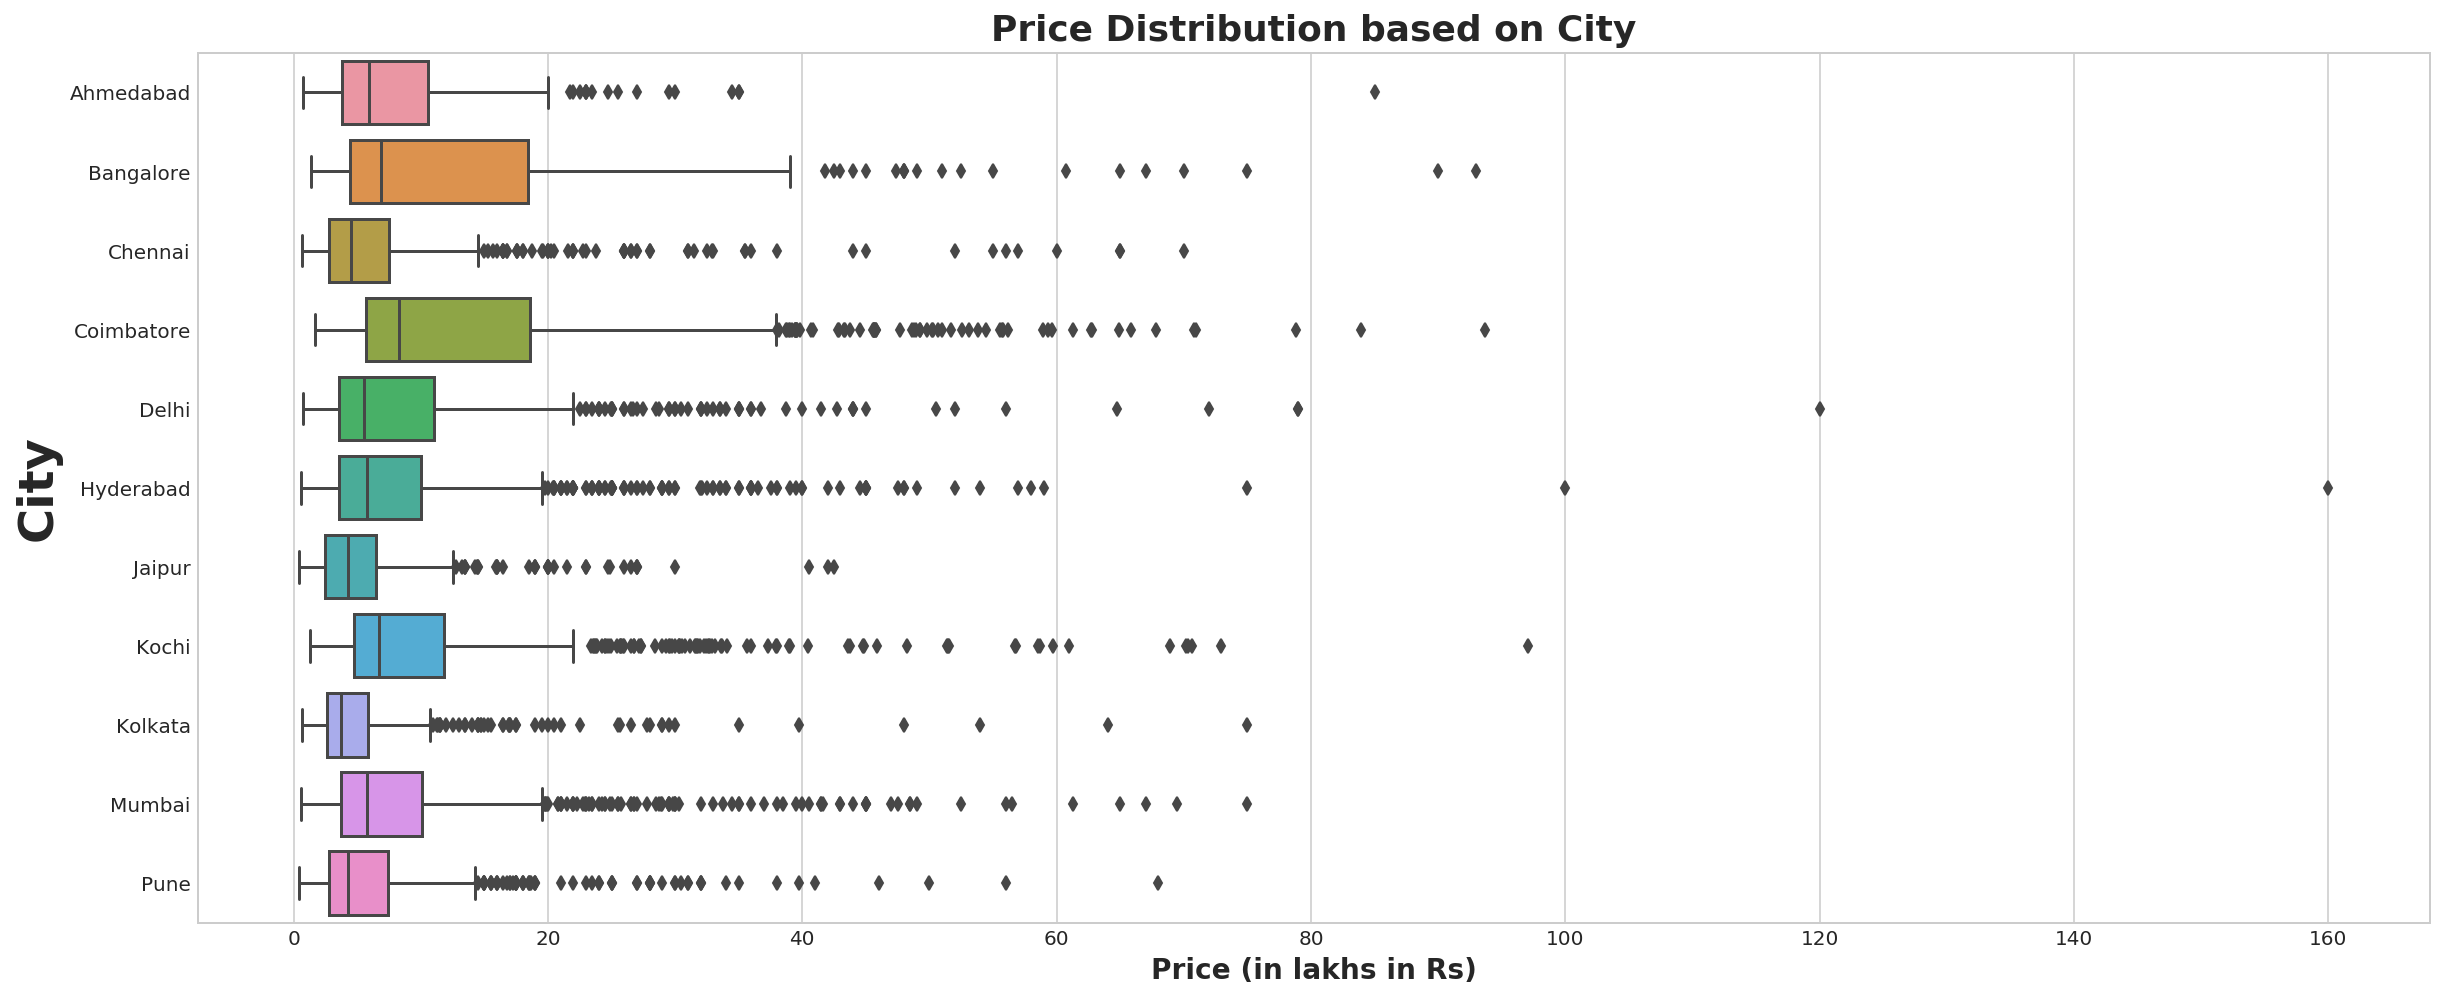

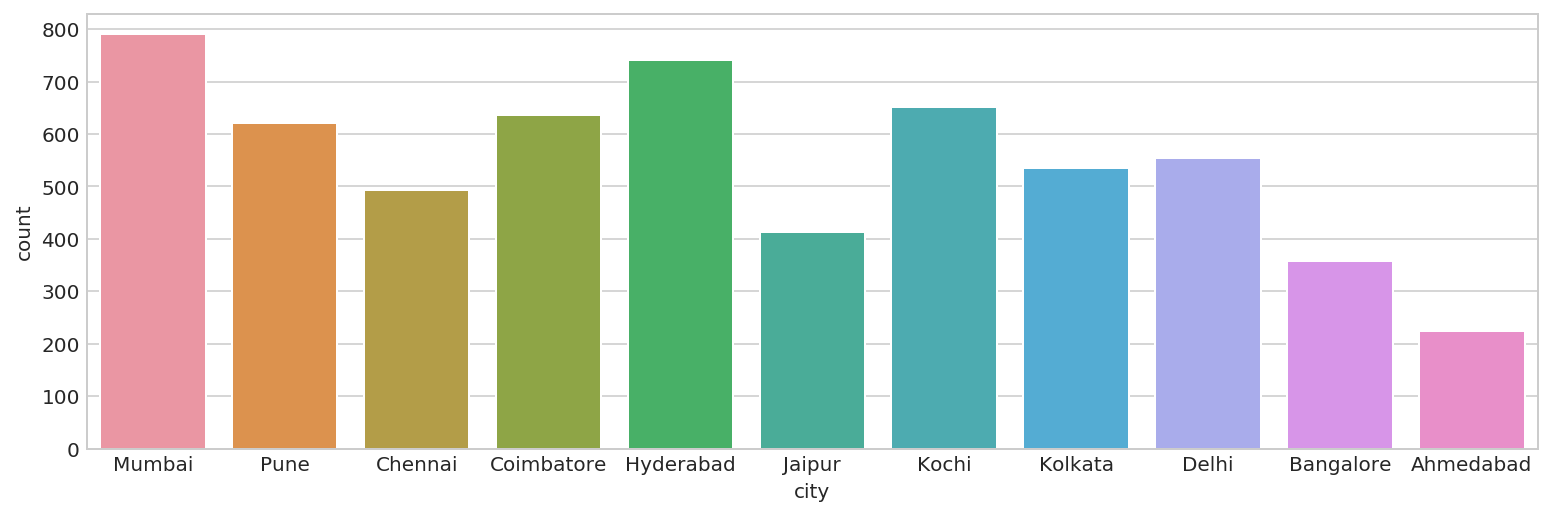

In [52]:
fig = plt.figure(figsize=(20,8))
ax = fig.gca()
sns.boxplot(x='price',y='city',data=cars,
            order=sorted(cars["city"].unique()),orient='h')
plt.xlabel('Price (in lakhs in Rs)',fontsize=14,fontweight="bold")
plt.ylabel('City',fontsize=24,fontweight="bold")
plt.title('Price Distribution based on City',fontsize=18,fontweight="bold")
plt.show()
plt.figure(figsize=(13,4))
ax = sns.countplot(x="city", data=cars)

___

# Random Forest
Random forest is a supervised learning algorithm. The "forest" it builds, is an ensemble of decision trees, usually trained with the “bagging” method. The general idea of the bagging method is that a combination of learning models increases the overall result.

Put simply: random forest builds multiple decision trees and merges them together to get a more accurate and stable prediction.

In [53]:
cars2=cars.copy()

# columns to be dropped
master_list=['name','power','mileage','city']
cars2=cars2.drop(master_list, axis=1)

### One-Hot Vectorization
We converted the categorical data into one-hot vectors. 

In [54]:
cars2=pd.get_dummies(cars2)

In [55]:
col_now=list(cars2.columns)
col_now.remove("price")
train_cols=col_now

In [56]:
from sklearn.model_selection import train_test_split
X = cars2[col_now]
y = cars2['price']

# split into train and test sets
'''Since this is the training set and the testing set is being explicitly exported below,
so for checking purposes, the initial training set is being reduced to just 0.0005 of the original size'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.0005, random_state=36062)

In [57]:
X_test.loc[:]

,year,kms,engine,seats,fuel_CNG,fuel_Diesel,fuel_Electric,fuel_LPG,fuel_Petrol,transmission_Automatic,...,model_Xcent,model_Xenon,model_Xylo,model_Yeti,model_Z4,model_Zen,model_Zest,model_i10,model_i20,model_redi-GO
1073,2013,67443,1248,7.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2268,2013,25984,1499,5.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1159,2018,50234,1197,5.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
952,2018,92056,2393,7.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [59]:
print(X_test.shape)

(4, 257)


In [60]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100, random_state=32321)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [61]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.6224249999999945
Mean Squared Error: 0.4223219624999923
Root Mean Squared Error: 0.6498630336463156


In [62]:
from sklearn.metrics import r2_score
#y_train=np.array([[1],[2],[3]])
#y_pred=y_train
coeff = r2_score(y_test, y_pred)
print(coeff)

0.9869243183265982


In [63]:
y_test=np.array([y_test])

In [64]:
pd.set_option('display.max_rows',60)
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df

,Actual,Predicted
0,5.75,5.2116
1,5.35,5.7198
2,4.77,5.6385
3,18.39,17.6770


## Dealing with the data of the test.xlsx for which values are to be predicted

In [65]:
#specifying the excel file to be used
excel_file2="Data_Test (1).xlsx"

'''Here, the read_excel method read the data from the Excel file into a pandas Data
Frame object. Pandas defaults to storing data in DataFrames'''
cars3 = pd.read_excel(excel_file2)

In [66]:
def preprocess(cars):
    cars.columns = [x.lower() for x in cars.columns]
    cars=cars.rename(columns={"location": "city","kilometers_driven":"kms","fuel_type":"fuel",
                    "owner_type":"owner",})
    a1=[]
    a2=[]
    for s in cars["name"]:
        ary=s.split(' ')
        a1.append(ary[0])
        a2.append(ary[1])
    brand=pd.Series(a1)
    model=pd.Series(a2)
    cars["brand"]=brand
    cars["model"]=model
    cars.loc[cars["brand"]=="Land","brand"]="Land_Rover"
    cars["seats"]=cars["seats"].fillna(5) 
    
    le=cars["engine"].isnull()
    for i in range(len(cars)):
        if le[i]==True:
            if cars["model"][i]=="Swift":
                cars.loc[i,"engine"]=1300
            if cars["model"][i]=="City":
                cars.loc[i,"engine"]=1500
            if cars["model"][i]=="Punto":
                cars.loc[i,"engine"]=1300
            if cars["model"][i]=="5":
                cars.loc[i,"engine"]=2000
            if cars["model"][i]=="Rover":
                cars.loc[i,"engine"]=3000
            if cars["model"][i]=="Santro":
                cars.loc[i,"engine"]=1086
            if cars["model"][i]=="Etios":
                cars.loc[i,"engine"]=1197
            if cars["model"][i]=="Wagon" or cars["model"][i]=="Wagon-R":
                cars.loc[i,"engine"]=998
            if cars["model"][i]=="CR-V":
                cars.loc[i,"engine"]=2354
            if cars["model"][i]=="Jazz":
                cars.loc[i,"engine"]=1198
            if cars["model"][i]=="Laura":
                cars.loc[i,"engine"]=1896
            if cars["model"][i]=="TUV":
                cars.loc[i,"engine"]=2179
            if cars["model"][i]=="i20":
                cars.loc[i,"engine"]=1399
        
    for i in range(len(cars)):
        st=cars["engine"][i]
        a=4
        b=2.0
        #c=2.0000000000000000000000
        #print(type(c))
        if type(st)!=type(a) and type(st)!=type(b) and type(st)!=type(np.float64(b)):
            le=""
            for j in st:
                if j==' ':
                    break
                le=le+j
            cars.loc[i,"engine"]=le

    cars["engine"]=pd.to_numeric(cars["engine"])
    return cars

In [67]:
cars3.isnull().sum()

Name                  0
Location              0
Year                  0
Kilometers_Driven     0
Fuel_Type             0
Transmission          0
Owner_Type            0
Mileage               0
Engine               10
Power                10
Seats                11
dtype: int64

In [68]:
cars3=preprocess(cars3)

In [69]:
cars3.shape

(1234, 13)

In [70]:
cars3[cars3['engine'].isnull()]

,name,city,year,kms,fuel,transmission,owner,mileage,engine,power,seats,brand,model


___

In [71]:
X_test2=[]
y_test2=[]

In [72]:
def predict_values(cars):
    #local cars2
    #cars3.head()
    cars2=cars.copy()    
    #print(cars2.columns)
    cars2=cars2.drop(master_list, axis=1)
    cars2=pd.get_dummies(cars2)
    test_cols=list(cars2.columns)
    type(test_cols)
    ######################################################################
    missing_cols = set( train_cols ) - set( test_cols )
    missing_cols2=set(test_cols)-set(train_cols)
    print(missing_cols)
    print(missing_cols2)
    # Add a missing column in test set with default value equal to 0
    for c in missing_cols:
        cars2[c] = 0
    # Ensure the order of column in the test set is in the same order than in train set
    cars2 =cars2[train_cols]
    #########################################################################
    X = cars2[train_cols]
    #y = cars2['price']
    print(X.shape)
    
    global sc
    global X_test2
    X_test = sc.transform(X)
    y_pred = regressor.predict(X_test)
    X_test2=X_test
    print(type(y_pred))
    new_series = pd.Series(y_pred)
    cars['Random_Forest_price']=new_series
    return cars

In [73]:
cars4=predict_values(cars3)

{'brand_Ambassador', 'model_Z4', 'model_Panamera', 'model_Lancer', 'model_Fluence', 'model_Nexon', 'model_Prius', 'model_RS5', 'model_MUX', 'model_Evalia', 'model_Logan', 'model_XUV300', 'model_Boxster', 'model_CLS-Class', 'model_E', 'model_1', 'model_Platinum', 'model_Continental', 'model_Siena', 'model_Jeep', 'model_WR-V', 'model_Santa', 'model_Bolt', 'model_Safari', 'model_Countryman', 'model_Fortwo', 'brand_Force', 'model_XJ', 'model_Fusion', 'model_X-Trail', 'model_Tiguan', 'model_Cayman', 'model_Aspire', 'model_Cedia', 'model_Petra', 'model_Mustang', 'model_Hexa', 'brand_Lamborghini', 'model_Venture', 'fuel_Electric', 'model_GLS', 'model_Scala', 'model_Yeti', 'model_Redi', 'model_Outlander', 'model_Gallardo', 'model_1000', 'model_One', 'model_C-Class', 'model_Estilo', 'model_S-Class', 'model_NuvoSport', 'model_TT', 'model_R-Class', 'model_A7', 'model_F', 'model_Fabia', 'model_S-Cross', 'brand_Smart', 'model_Beetle', 'model_SLK-Class', 'model_Montero', 'model_SL-Class'}
{'model_Mo

In [74]:
'''y_exp=[]
y_got=[]
cnt=0
for i in range(len(cars4)):
    ans=2.0
    model_a=cars4["model"][i]
    year_a=cars4['year'][i]
    df=cars.loc[((cars['model'] ==model_a) & (abs(cars['year']-year_a) < 4))]
    if len(df)>0:
        ans=df['price'].mean()
    else:
        cnt+=1
    y_exp.append(ans);
print(cnt)'''

'y_exp=[]\ny_got=[]\ncnt=0\nfor i in range(len(cars4)):\n    ans=2.0\n    model_a=cars4["model"][i]\n    year_a=cars4[\'year\'][i]\n    df=cars.loc[((cars[\'model\'] ==model_a) & (abs(cars[\'year\']-year_a) < 4))]\n    if len(df)>0:\n        ans=df[\'price\'].mean()\n    else:\n        cnt+=1\n    y_exp.append(ans);\nprint(cnt)'

In [75]:
y_given=np.array(cars4['Random_Forest_price'])
len(y_given)
y_test2=y_given

In [76]:
y_given=pd.Series(y_given)
y_given.fillna(y_given.median())
y_given=np.array(y_given)

In [77]:
#coeff2 = r2_score(y_exp, y_given)
#print(coeff2)

In [78]:
np.any(np.isnan(y_given))

False

In [79]:
X_test2

array([[ 0.19673776, -0.1950855 , -1.03605015, ..., -0.16317385,
        -0.20693591, -0.03159909],
       [-0.1091236 , -0.04650321, -1.37209364, ..., -0.16317385,
        -0.20693591, -0.03159909],
       [ 1.11432184, -0.27098691,  1.28464622, ..., -0.16317385,
        -0.20693591, -0.03159909],
       ...,
       [-0.41498497, -0.3367119 , -0.26581186, ..., -0.16317385,
        -0.20693591, -0.03159909],
       [-0.1091236 , -0.07094195, -0.70499741, ..., -0.16317385,
        -0.20693591, -0.03159909],
       [ 0.19673776,  0.15012405,  0.87706872, ..., -0.16317385,
        -0.20693591, -0.03159909]])

In [80]:
np.all(np.isfinite(y_given))

True

In [81]:
#new_series = pd.Series(y_exp)
#cars4['exp_price']=new_series

In [82]:
cars4.loc[:]

,name,city,year,kms,fuel,transmission,owner,mileage,engine,power,seats,brand,model,Random_Forest_price
0,Maruti Alto K10 LXI CNG,Delhi,2014,40929,CNG,Manual,First,32.26 km/kg,998,58.2 bhp,4.0,Maruti,Alto,3.0924
1,Maruti Alto 800 2016-2019 LXI,Coimbatore,2013,54493,Petrol,Manual,Second,24.7 kmpl,796,47.3 bhp,5.0,Maruti,Alto,2.2491
2,Toyota Innova Crysta Touring Sport 2.4 MT,Mumbai,2017,34000,Diesel,Manual,First,13.68 kmpl,2393,147.8 bhp,7.0,Toyota,Innova,17.3616
3,Toyota Etios Liva GD,Hyderabad,2012,139000,Diesel,Manual,First,23.59 kmpl,1364,null bhp,5.0,Toyota,Etios,3.7711
4,Hyundai i20 Magna,Mumbai,2014,29000,Petrol,Manual,First,18.5 kmpl,1197,82.85 bhp,5.0,Hyundai,i20,5.2811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1229,Volkswagen Vento Diesel Trendline,Hyderabad,2011,89411,Diesel,Manual,First,20.54 kmpl,1598,103.6 bhp,5.0,Volkswagen,Vento,3.8430
1230,Volkswagen Polo GT TSI,Mumbai,2015,59000,Petrol,Automatic,First,17.21 kmpl,1197,103.6 bhp,5.0,Volkswagen,Polo,6.4333
1231,Nissan Micra Diesel XV,Kolkata,2012,28000,Diesel,Manual,First,23.08 kmpl,1461,63.1 bhp,5.0,Nissan,Micra,3.1566
1232,Volkswagen Polo GT TSI,Pune,2013,52262,Petrol,Automatic,Third,17.2 kmpl,1197,103.6 bhp,5.0,Volkswagen,Polo,4.1258


In [83]:
'''fig, ax = plt.subplots()
ax.scatter(y_exp,y_given)
#ax.plot([y_exp.min(), y_exp.max()], [y_exp.min(), y_exp.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()'''

"fig, ax = plt.subplots()\nax.scatter(y_exp,y_given)\n#ax.plot([y_exp.min(), y_exp.max()], [y_exp.min(), y_exp.max()], 'k--', lw=4)\nax.set_xlabel('Measured')\nax.set_ylabel('Predicted')\nplt.show()"

___


## XGBoost
The XGBoost library implements the gradient boosting decision tree algorithm.

This algorithm goes by lots of different names such as gradient boosting, multiple additive regression trees, stochastic gradient boosting or gradient boosting machines.

Boosting is an ensemble technique where new models are added to correct the errors made by existing models. Models are added sequentially until no further improvements can be made. 

### Hyperparameter optimisations

In [84]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [85]:
def hyperParameterTuning(x_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'eta': [0.01,0.3]
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_


In [86]:
#Run below line for double checking only, can run upto 5 mins

# hyperParameterTuning(X_train, y_train)


#the above line gives us an output of the following

# {'colsample_bytree': 0.7,
#  'learning_rate': 0.01,
#  'max_depth': 10,
#  'min_child_weight': 1,
#  'subsample': 0.7}


In [87]:
X_test

array([[-0.1091236 ,  0.09535323, -0.62015475, ..., -0.16317385,
        -0.20693591, -0.03159909],
       [-0.1091236 , -0.35879549, -0.20259576, ..., -0.16317385,
        -0.20693591, -0.03159909],
       [ 1.4201832 , -0.09315699, -0.70499741, ..., -0.16317385,
        -0.20693591, -0.03159909],
       [ 1.4201832 ,  0.36496809,  1.28464622, ..., -0.16317385,
        -0.20693591, -0.03159909]])

In [88]:
y_test2 = y_test2.transpose()
y_test2.shape

(1234,)

In [89]:
X_test2

array([[ 0.19673776, -0.1950855 , -1.03605015, ..., -0.16317385,
        -0.20693591, -0.03159909],
       [-0.1091236 , -0.04650321, -1.37209364, ..., -0.16317385,
        -0.20693591, -0.03159909],
       [ 1.11432184, -0.27098691,  1.28464622, ..., -0.16317385,
        -0.20693591, -0.03159909],
       ...,
       [-0.41498497, -0.3367119 , -0.26581186, ..., -0.16317385,
        -0.20693591, -0.03159909],
       [-0.1091236 , -0.07094195, -0.70499741, ..., -0.16317385,
        -0.20693591, -0.03159909],
       [ 0.19673776,  0.15012405,  0.87706872, ..., -0.16317385,
        -0.20693591, -0.03159909]])

In [90]:
#input the hyperparameters and we are done
xgb_model = XGBRegressor(
        colsample_bytree= 0.7,
        learning_rate= 0.01,
        max_depth= 10,
        min_child_weight= 1,
        n_estimators= 1000,
        subsample= 0.7)

xgb_model.fit(X_train, y_train)
predictions = xgb_model.predict(X_test2)
r2_score(predictions,y_test2)

[22:30:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.9892042976229981

In [91]:
new_series = pd.Series(predictions)
cars4['XGB_price']=new_series

#pd.set_option('display.max_rows', 7000)
cars4.loc[:]
cars4.dtypes

name                    object
city                    object
year                     int64
kms                      int64
fuel                    object
transmission            object
owner                   object
mileage                 object
engine                   int64
power                   object
seats                  float64
brand                   object
model                   object
Random_Forest_price    float64
XGB_price              float32
dtype: object

# Results

In [92]:
pd.set_option('display.max_rows', 100)

In [93]:
cars4.loc[:]

,name,city,year,kms,fuel,transmission,owner,mileage,engine,power,seats,brand,model,Random_Forest_price,XGB_price
0,Maruti Alto K10 LXI CNG,Delhi,2014,40929,CNG,Manual,First,32.26 km/kg,998,58.2 bhp,4.0,Maruti,Alto,3.0924,2.935872
1,Maruti Alto 800 2016-2019 LXI,Coimbatore,2013,54493,Petrol,Manual,Second,24.7 kmpl,796,47.3 bhp,5.0,Maruti,Alto,2.2491,2.431911
2,Toyota Innova Crysta Touring Sport 2.4 MT,Mumbai,2017,34000,Diesel,Manual,First,13.68 kmpl,2393,147.8 bhp,7.0,Toyota,Innova,17.3616,17.778378
3,Toyota Etios Liva GD,Hyderabad,2012,139000,Diesel,Manual,First,23.59 kmpl,1364,null bhp,5.0,Toyota,Etios,3.7711,3.737540
4,Hyundai i20 Magna,Mumbai,2014,29000,Petrol,Manual,First,18.5 kmpl,1197,82.85 bhp,5.0,Hyundai,i20,5.2811,4.667237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1229,Volkswagen Vento Diesel Trendline,Hyderabad,2011,89411,Diesel,Manual,First,20.54 kmpl,1598,103.6 bhp,5.0,Volkswagen,Vento,3.8430,3.901878
1230,Volkswagen Polo GT TSI,Mumbai,2015,59000,Petrol,Automatic,First,17.21 kmpl,1197,103.6 bhp,5.0,Volkswagen,Polo,6.4333,5.663555
1231,Nissan Micra Diesel XV,Kolkata,2012,28000,Diesel,Manual,First,23.08 kmpl,1461,63.1 bhp,5.0,Nissan,Micra,3.1566,3.704683
1232,Volkswagen Polo GT TSI,Pune,2013,52262,Petrol,Automatic,Third,17.2 kmpl,1197,103.6 bhp,5.0,Volkswagen,Polo,4.1258,4.207714


In [94]:
cars4.to_excel("output.xlsx")  

# Final Conclusions
Like most data science problems, this work would have undoubtedly benefitted from cleaner (and more) data. While the details provided in the downloaded listings are quite comprehensive,some features, especially 'name',seemed to have too many variations with even the same car model having multiple sub-categories.

We utilized several classic and state-of-the-art methods, including
ensemble learning techniques, with a 90-10 split on test and training
data.



| Model             	| R2 scores for a 90-10 split on Training data 	|
|-------------------	|----------------------------------------------	|
| XgBoost           	| 0.95                                         	|
| RandomForest      	| 0.927                                        	|
| Linear Regression 	| 0.60                                         	|
| Gradient Boosting 	| 0.90                                         	|

Although the scores predicted by both **XgBoost** and **Random Forest** seem quite reasonable, ***XgBoost seems to give slightly better results than RandomForest and this is the one we use for the final model.***